<a href="https://colab.research.google.com/github/sheikh495/aining-Networks-with-Tensorflow-and-Keras/blob/main/boka_shannon_uddin_cosc525_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project \#3: Training Networks with Tensorflow and Keras
## COSC 525: Deep Learning (Spring 2023)
### Kyle Shannon, Simon Boka & Sheikh Uddin (Group 1)


Introduction:

The focus of this project is to train a machine learning algorithm utilizing images from the FairFace dataset to build an image classifier based on using race, gender, and age as trainable attibutes. Per the project scope, the two attributes that our group chose to use to train our model were race and gender. The FairFace dataset consisted of 86,744 training face images and 10,954 validation face images, which were resized to 32x32 pixels and converted to grayscale to decrease training time. Our report will cover the details and processes utilized to execute the assignment task, which consisted fully connected neural network, small convolutional neural network, customized convolutional neural network, and variational autoencoder networks. The completion of these tasks allowed for the classification images based on either one or both attributes. The evaluation is carried out by recording the loss value for each epoch and creating epoch-loss and accuracy-loss plots for both the training and validation sets. Finally, the report presents the final classification accuracy and the confusion matrix for each network.


# Packages Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image

# Restoring Session / Loading Data

## Session Package

In [ ]:
try:
  import dill
except:
  # !pip install dill
  import dill

## Setting Root Directory

In [ ]:
from os import path
try:
  from google.colab import drive
  drive.mount('/content/drive/') # Mounting Shared Drive
  ROOT_DIR = '/content/drive/MyDrive/Boka_Shannon_Uddin_Project3/'
except:
  ROOT_DIR = path.abspath(path.curdir)

# Path to dump file
session_dump = path.join(ROOT_DIR, 'Project3_Boka_Shannon_Uddin.pkl')

# Attributes for image dataset
ATTRIBUTES = ['age', 'gender', 'race']

## Function to load a subset of data

In [ ]:
def load_datasets(df, nrows=10):
    y = df[:nrows] if 0 < nrows < len(df) else df
    X = np.array([image.img_to_array(image.load_img(path.join(ROOT_DIR, file))) for file in y.file]) / 255.0  # Normalize images
    y = y[ATTRIBUTES]
    return X, y

## Restore Existing Session

In [ ]:
if path.exists(session_dump):
    # Load Previous Session
    dill.load_session(session_dump)

## Save New Session (Only Run to Reload the data)

In [ ]:
if not path.exists(session_dump):
    # Load the data
    train_df = pd.read_csv(path.join(ROOT_DIR, 'fairface_label_train.csv'))
    valid_df = pd.read_csv(path.join(ROOT_DIR, 'fairface_label_val.csv'))

    # Load Training and Testing Sets
    train_images, train_labels = load_datasets(train_df, 200)
    valid_images, valid_labels = load_datasets(valid_df, 40)

    # Save Session
    dill.dump_session(session_dump)

## Classes & Encoded Labels

In [ ]:
def classes_and_encoded_labels(attributes):
    global train_labels, valid_labels
    n_classes = {}
    n_labels = {}

    for attribute in attributes:
        # Find number of classes
        _classes = {label: i for i, label in enumerate(pd.concat([train_labels[attribute], valid_labels[attribute]]).unique())}
        n_classes[attribute] = _classes

        # Convert Label to integer
        y_train = np.array([_classes[label] for label in train_labels[attribute]])
        y_test = np.array([_classes[label] for label in valid_labels[attribute]])

        # Convert labels to one-hot encoding
        training_labels = tf.keras.utils.to_categorical(y_train, len(_classes))
        test_labels = tf.keras.utils.to_categorical(y_test, len(_classes))
        n_labels[attribute] = {'train': training_labels, "test": test_labels}
    return n_classes, n_labels

# Task 1: Fully Connected Neural Network

## Format Classes & Labels

In [ ]:
n_classes, n_labels = classes_and_encoded_labels(['gender', 'race'])

## Create Model

In [ ]:
def create_attribute_model(attribute:str, input_shape, learning_rate=0.01):
    global classes
    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(1024, activation='tanh'),
        tf.keras.layers.Dense(512, activation='sigmoid'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation='softmax')
    ], name=f"Sequential_{attribute.capitalize()}")

    # Define optimizer and loss function
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.6)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    return model

## Train Model

In [ ]:
def train_attribute_model(model, train_labels, test_labels, batch_size=32, epochs=10, validation_split=0.2):
    global X_train, X_test
    # Train the model
    history = model.fit(X_train, train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

    # Evaluate the model
    result = model.evaluate(X_test, test_labels)
    print("Final Results:", dict(zip(model.metrics_names, result)))
    return history

## Confusion Matrix Heatmap

In [ ]:
def plot_confusion_matrix(cm:tf.Tensor, classes):
    # Extract the confusion matrix
    cm = cm.numpy()
    
    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_aspect('equal')
    plt.title('Confusion Matrix')
    plt.show()

## Epoch Loss Graph

In [ ]:
def plot_epcoh_loss(train_history):
    # Extract the loss values for the training and validation sets from the history object
    train_loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']

    # Plot the epoch-loss curve
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Epoch-Loss Plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Accuracy Loss

In [ ]:
def plot_accuracy_loss(history):
    # Get training and validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

## Scaling Images

In [ ]:
# Scale the data using Min-Max scaling
X_train = (train_images - train_images.min()) / (train_images.max() - train_images.min())
X_test = (valid_images - train_images.min()) / (train_images.max() - train_images.min())

## Gender Classifier Model

In [ ]:
classes =  n_classes['gender']
y_train = n_labels['gender']['train']
y_test = n_labels['gender']['test']

In [ ]:
model = create_attribute_model("gender", X_train[-1].shape)
model.summary()

Model: "Sequential_Gender"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 3072)              0         
                                                                 
 dense_48 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_49 (Dense)            (None, 512)               524800    
                                                                 
 dense_50 (Dense)            (None, 100)               51300     
                                                                 
 dense_51 (Dense)            (None, 2)                 202       
                                                                 
Total params: 3,723,054
Trainable params: 3,723,054
Non-trainable params: 0
_________________________________________________________________


### Training

In [ ]:
history = train_attribute_model(model, y_train, y_test)

Epoch 1/10
5/5 [==============================] - 4s 331ms/step - loss: 0.7206 - accuracy: 0.4563 - val_loss: 0.7855 - val_accuracy: 0.3750
Epoch 2/10
5/5 [==============================] - 1s 122ms/step - loss: 0.7198 - accuracy: 0.4625 - val_loss: 0.7142 - val_accuracy: 0.3750
Epoch 3/10
5/5 [==============================] - 1s 125ms/step - loss: 0.7222 - accuracy: 0.4875 - val_loss: 0.7198 - val_accuracy: 0.4000
Epoch 4/10
5/5 [==============================] - 1s 135ms/step - loss: 0.7168 - accuracy: 0.4625 - val_loss: 0.6718 - val_accuracy: 0.6250
Epoch 5/10
5/5 [==============================] - 1s 109ms/step - loss: 0.7130 - accuracy: 0.4938 - val_loss: 0.7011 - val_accuracy: 0.4500
Epoch 6/10
5/5 [==============================] - 1s 134ms/step - loss: 0.6782 - accuracy: 0.5562 - val_loss: 0.7235 - val_accuracy: 0.4000
Epoch 7/10
5/5 [==============================] - 1s 137ms/step - loss: 0.6804 - accuracy: 0.5437 - val_loss: 0.7058 - val_accuracy: 0.4000
Epoch 8/10
5/5 [====

### Prediction

In [ ]:
# Predict the labels of the validation set
valid_preds = model.predict(X_test)
valid_preds = np.argmax(valid_preds, axis=1)

# Calculate the confusion matrix
conf_mat = tf.math.confusion_matrix(np.argmax(y_test, axis=1), valid_preds)
print('Confusion matrix:')
print(conf_mat)

2/2 [==============================] - 0s 11ms/step
Confusion matrix:
tf.Tensor(
[[20  0]
 [20  0]], shape=(2, 2), dtype=int32)


### Confusion Matrix

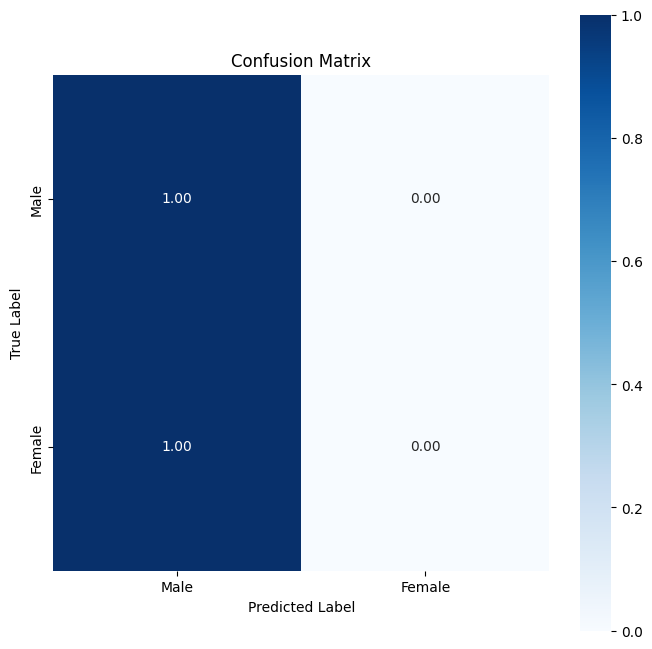

In [ ]:
plot_confusion_matrix(conf_mat, classes.keys())

### Epoch Loss

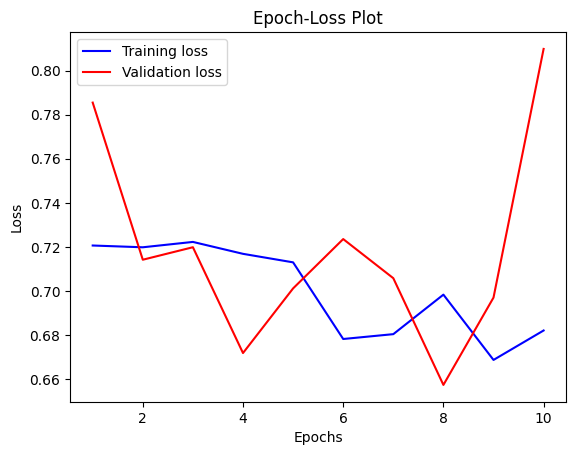

In [ ]:
plot_epcoh_loss(history)

### Acuracy Loss

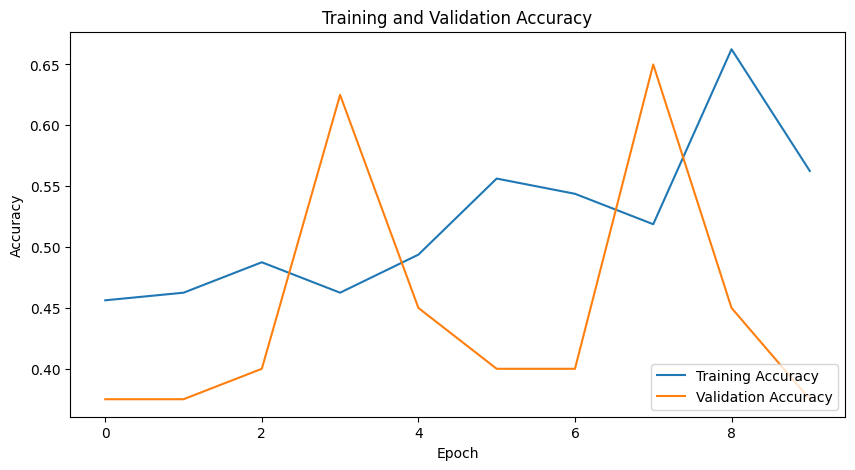

In [ ]:
plot_accuracy_loss(history)

## Race Classifier Model

In [ ]:
classes =  n_classes['race']
y_train = n_labels['race']['train']
y_test = n_labels['race']['test']

In [ ]:
model = create_attribute_model("race", X_train[-1].shape)
model.summary()

Model: "Sequential_Race"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 3072)              0         
                                                                 
 dense_52 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_53 (Dense)            (None, 512)               524800    
                                                                 
 dense_54 (Dense)            (None, 100)               51300     
                                                                 
 dense_55 (Dense)            (None, 7)                 707       
                                                                 
Total params: 3,723,559
Trainable params: 3,723,559
Non-trainable params: 0
_________________________________________________________________


### Training

In [ ]:
history = train_attribute_model(model, y_train, y_test)

Epoch 1/10
5/5 [==============================] - 3s 331ms/step - loss: 1.9874 - accuracy: 0.1625 - val_loss: 1.9254 - val_accuracy: 0.2250
Epoch 2/10
5/5 [==============================] - 0s 108ms/step - loss: 1.9594 - accuracy: 0.1437 - val_loss: 1.9484 - val_accuracy: 0.2250
Epoch 3/10
5/5 [==============================] - 1s 129ms/step - loss: 1.9257 - accuracy: 0.1813 - val_loss: 1.9280 - val_accuracy: 0.2250
Epoch 4/10
5/5 [==============================] - 1s 112ms/step - loss: 1.9113 - accuracy: 0.2000 - val_loss: 1.9389 - val_accuracy: 0.2250
Epoch 5/10
5/5 [==============================] - 1s 150ms/step - loss: 1.9100 - accuracy: 0.2375 - val_loss: 1.9303 - val_accuracy: 0.2250
Epoch 6/10
5/5 [==============================] - 1s 127ms/step - loss: 1.8902 - accuracy: 0.2375 - val_loss: 1.9543 - val_accuracy: 0.2500
Epoch 7/10
5/5 [==============================] - 1s 120ms/step - loss: 1.8789 - accuracy: 0.2375 - val_loss: 1.9604 - val_accuracy: 0.2500
Epoch 8/10
5/5 [====

### Prediction

In [ ]:
# Predict the labels of the validation set
valid_preds = model.predict(X_test)
valid_preds = np.argmax(valid_preds, axis=1)

# Calculate the confusion matrix
conf_mat = tf.math.confusion_matrix(np.argmax(y_test, axis=1), valid_preds)
print('Confusion matrix:')
print(conf_mat)

2/2 [==============================] - 36s 14ms/step
Confusion matrix:
tf.Tensor(
[[0 4 0 3 0 3 0]
 [0 3 0 2 0 0 0]
 [0 2 0 2 0 0 0]
 [0 4 0 1 0 0 0]
 [0 1 0 3 0 0 0]
 [0 2 0 5 0 0 0]
 [0 1 0 3 0 1 0]], shape=(7, 7), dtype=int32)


### Confusion Matrix

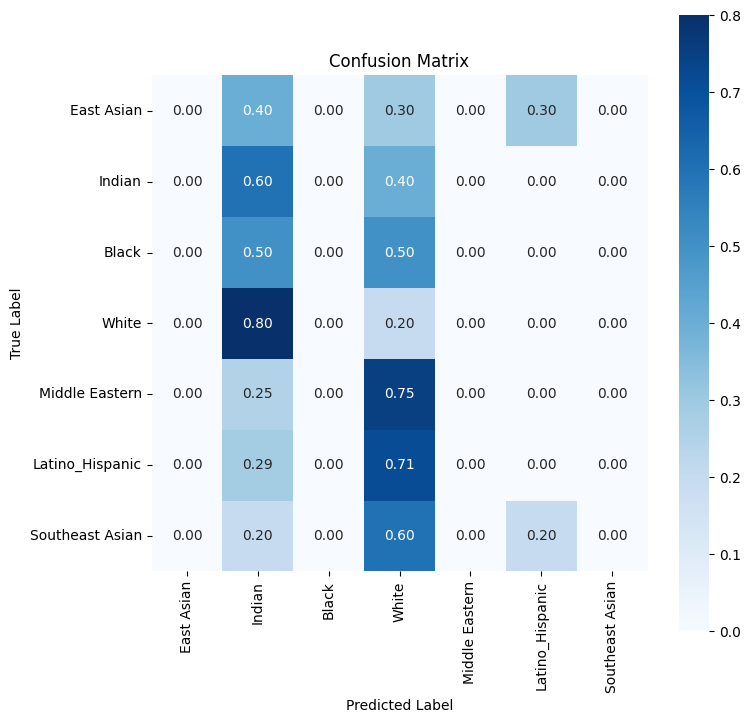

In [ ]:
plot_confusion_matrix(conf_mat, classes.keys())

### Epoch Loss

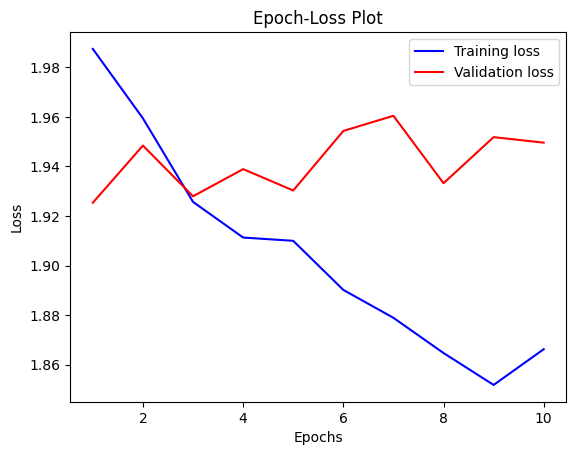

In [ ]:
plot_epcoh_loss(history)

### Acuracy Loss

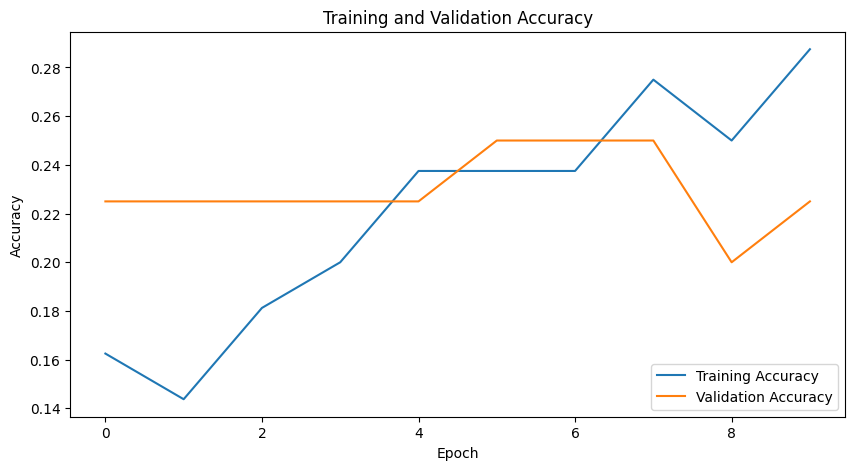

In [ ]:
plot_accuracy_loss(history)

# Task 2: Small Convolutional Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## Scaling Images

In [ ]:
# Scale the data using Min-Max scaling
X_train = (train_images - train_images.min()) / (train_images.max() - train_images.min())
X_test = (valid_images - train_images.min()) / (train_images.max() - train_images.min())

## Small CNN Model

In [ ]:
def cnn_model(attribute):
    global classes, X_train

    # Define the model architecture
    model = Sequential([
        Conv2D(40, (5, 5), activation='relu', input_shape=X_train[-1].shape),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(len(classes), activation='softmax')
    ], name=f"Sequential_{attribute.capitalize()}")

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.05, momentum=0.9), loss=categorical_crossentropy, metrics=[Accuracy()])

    return model

## Prediction & Confusion Matrix

In [ ]:
def predict(model):
    global X_test, y_test
    # Predict the labels of the validation set
    valid_preds = model.predict(X_test)
    valid_preds = np.argmax(valid_preds, axis=1)

    # Calculate the confusion matrix
    conf_mat = tf.math.confusion_matrix(np.argmax(y_test, axis=1), valid_preds)
    print('Confusion matrix:')
    print(conf_mat)
    return valid_preds, conf_mat

## Train Based on Gender

In [ ]:
classes =  n_classes['gender']
y_train = n_labels['gender']['train']
y_test = n_labels['gender']['test']

In [ ]:
cnn = cnn_model('gender')
cnn.summary()

Model: "Sequential_Gender"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 40)        3040      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 40)       0         
 2D)                                                             
                                                                 
 flatten_20 (Flatten)        (None, 7840)              0         
                                                                 
 dense_56 (Dense)            (None, 100)               784100    
                                                                 
 dense_57 (Dense)            (None, 2)                 202       
                                                                 
Total params: 787,342
Trainable params: 787,342
Non-trainable params: 0
___________________________________________

### Training

In [ ]:
history = train_attribute_model(cnn, y_train, y_test)

Epoch 1/10
5/5 [==============================] - 1s 139ms/step - loss: 0.7562 - accuracy: 0.0000e+00 - val_loss: 0.6915 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 59ms/step - loss: 0.6949 - accuracy: 0.0000e+00 - val_loss: 0.7154 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 62ms/step - loss: 0.6905 - accuracy: 0.0000e+00 - val_loss: 0.7073 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 55ms/step - loss: 0.6873 - accuracy: 0.0000e+00 - val_loss: 0.6868 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 62ms/step - loss: 0.6862 - accuracy: 0.0000e+00 - val_loss: 0.7017 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 63ms/step - loss: 0.6786 - accuracy: 0.0000e+00 - val_loss: 0.6397 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 69ms/step - loss: 0.7063 - accuracy: 0.0000e+00 - val_loss: 0.72

### Prediction

In [ ]:
y_pred, conf_mat = predict(cnn)

2/2 [==============================] - 0s 7ms/step
Confusion matrix:
tf.Tensor(
[[ 4 16]
 [ 1 19]], shape=(2, 2), dtype=int32)


### Confusion Matrix

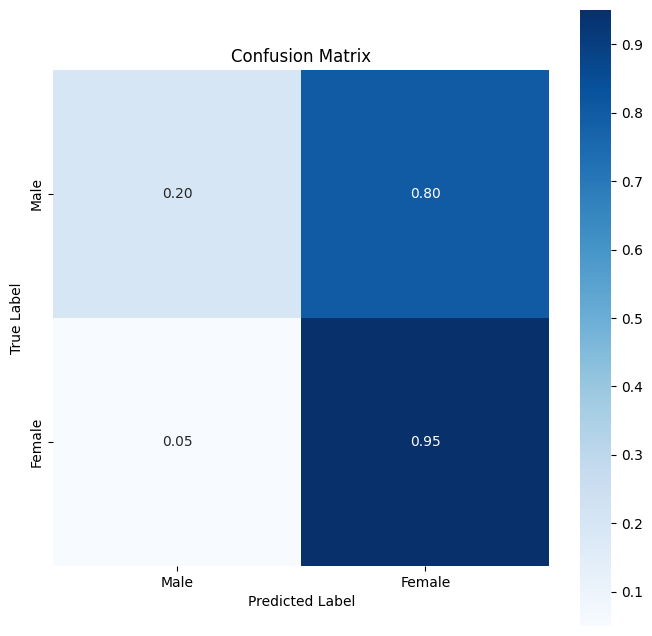

In [ ]:
plot_confusion_matrix(conf_mat, classes.keys())

### Epoch Loss

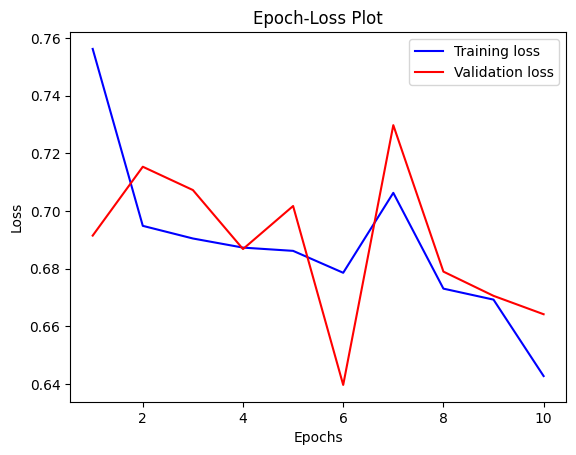

In [ ]:
plot_epcoh_loss(history)

### Accuracy Loss

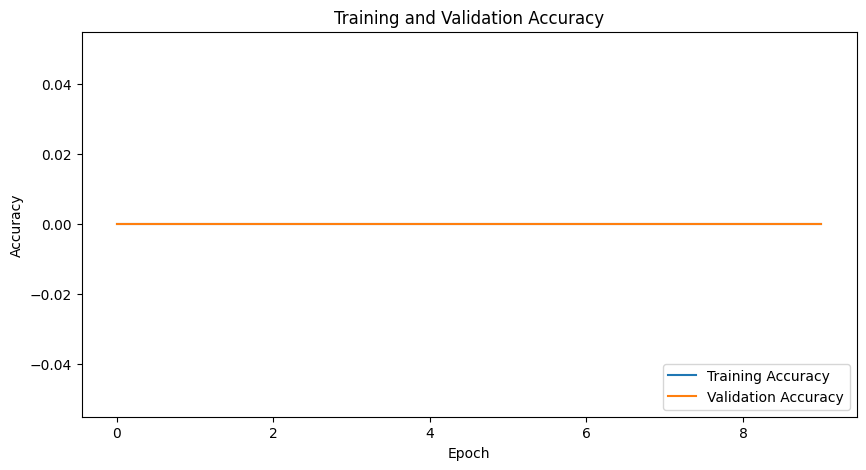

In [ ]:
plot_accuracy_loss(history)

## Train Based on Race

In [ ]:
classes =  n_classes['race']
y_train = n_labels['race']['train']
y_test = n_labels['race']['test']

In [ ]:
cnn = cnn_model('race')
cnn.summary()

Model: "Sequential_Race"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 28, 28, 40)        3040      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 40)       0         
 2D)                                                             
                                                                 
 flatten_21 (Flatten)        (None, 7840)              0         
                                                                 
 dense_58 (Dense)            (None, 100)               784100    
                                                                 
 dense_59 (Dense)            (None, 7)                 707       
                                                                 
Total params: 787,847
Trainable params: 787,847
Non-trainable params: 0
_____________________________________________

### Training

In [ ]:
history = train_attribute_model(cnn, y_train, y_test)

Epoch 1/10
5/5 [==============================] - 2s 145ms/step - loss: 1.9828 - accuracy: 0.0000e+00 - val_loss: 1.9395 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 96ms/step - loss: 1.9155 - accuracy: 0.0000e+00 - val_loss: 1.9471 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 58ms/step - loss: 1.9406 - accuracy: 0.0000e+00 - val_loss: 1.9271 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 75ms/step - loss: 1.8915 - accuracy: 0.0000e+00 - val_loss: 1.9777 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 67ms/step - loss: 1.9481 - accuracy: 0.0000e+00 - val_loss: 1.9317 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 67ms/step - loss: 1.8980 - accuracy: 0.0000e+00 - val_loss: 1.9225 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 66ms/step - loss: 1.8795 - accuracy: 0.0000e+00 - val_loss: 1.89

### Prediction

In [ ]:
y_pred, conf_mat = predict(cnn)

2/2 [==============================] - 0s 7ms/step
Confusion matrix:
tf.Tensor(
[[0 5 0 5 0 0 0]
 [0 3 0 2 0 0 0]
 [0 3 0 1 0 0 0]
 [0 4 0 1 0 0 0]
 [0 3 0 1 0 0 0]
 [0 3 0 4 0 0 0]
 [0 3 0 2 0 0 0]], shape=(7, 7), dtype=int32)


### Confusion Matrix

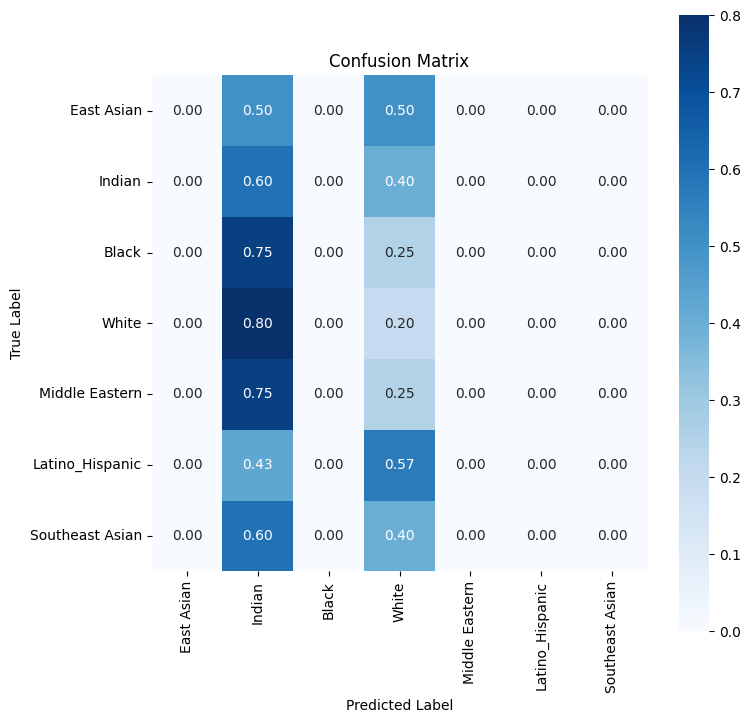

In [ ]:
plot_confusion_matrix(conf_mat, classes.keys())

### Epoch Loss

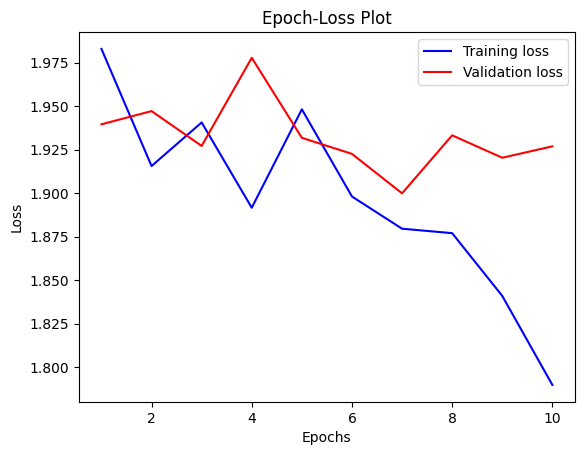

In [ ]:
plot_epcoh_loss(history)

### Accuracy Loss

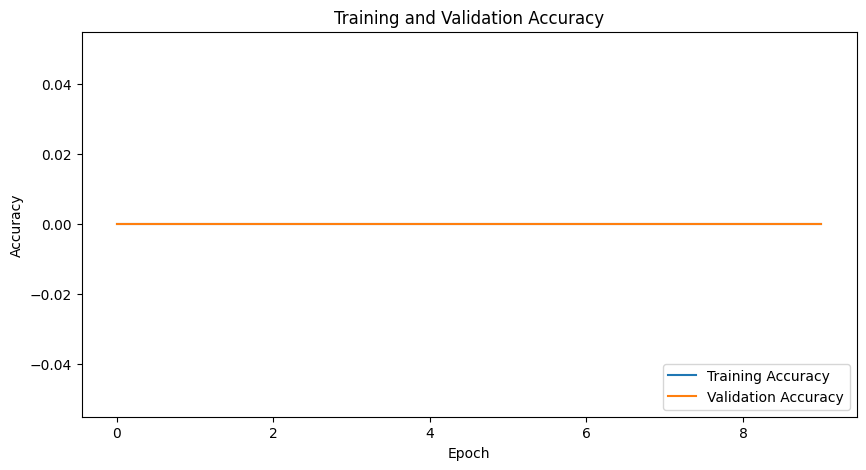

In [ ]:
plot_accuracy_loss(history)

# Task 3: Your own Convolutional Neural Network

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import SGD

### Scaling Images

In [ ]:
# Scale the data using Min-Max scaling
X_train = (train_images - train_images.min()) / (train_images.max() - train_images.min())
X_test = (valid_images - train_images.min()) / (train_images.max() - train_images.min())

## OWN CNN Model

In [ ]:
def own_cnn_model(attribute:str):
    global classes, X_test

    # Define the model architecture
    model = Sequential(name=f"Sequential_{attribute.capitalize()}")

    # Add Layers to model
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_test[-1].shape))
    model.add(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(classes), activation='softmax'))

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.7), loss=categorical_crossentropy, metrics=[Accuracy()])

    return model

## Create the Model

In [ ]:
classes =  n_classes['race']
y_train = n_labels['race']['train']
y_test = n_labels['race']['test']

In [ ]:
own_cnn = own_cnn_model('race')
own_cnn.summary()

Model: "Sequential_Race"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 64)         0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 1024)          

## Train the Model

In [ ]:
history = train_attribute_model(own_cnn, y_train, y_test)

Epoch 1/10
5/5 [==============================] - 2s 149ms/step - loss: 1.9435 - accuracy: 0.0000e+00 - val_loss: 1.9375 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 83ms/step - loss: 1.9215 - accuracy: 0.0000e+00 - val_loss: 1.9276 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 75ms/step - loss: 1.9075 - accuracy: 0.0000e+00 - val_loss: 1.9336 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 86ms/step - loss: 1.8979 - accuracy: 0.0000e+00 - val_loss: 1.9474 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 73ms/step - loss: 1.9012 - accuracy: 0.0000e+00 - val_loss: 1.9375 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 81ms/step - loss: 1.8942 - accuracy: 0.0000e+00 - val_loss: 1.9322 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 78ms/step - loss: 1.8721 - accuracy: 0.0000e+00 - val_loss: 1.97

## Predict

In [ ]:
y_pred, cm = predict(own_cnn)

2/2 [==============================] - 0s 12ms/step
Confusion matrix:
tf.Tensor(
[[ 0 10  0  0  0  0  0]
 [ 0  5  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  5  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  7  0  0  0  0  0]
 [ 0  5  0  0  0  0  0]], shape=(7, 7), dtype=int32)


## Confusion Matrix

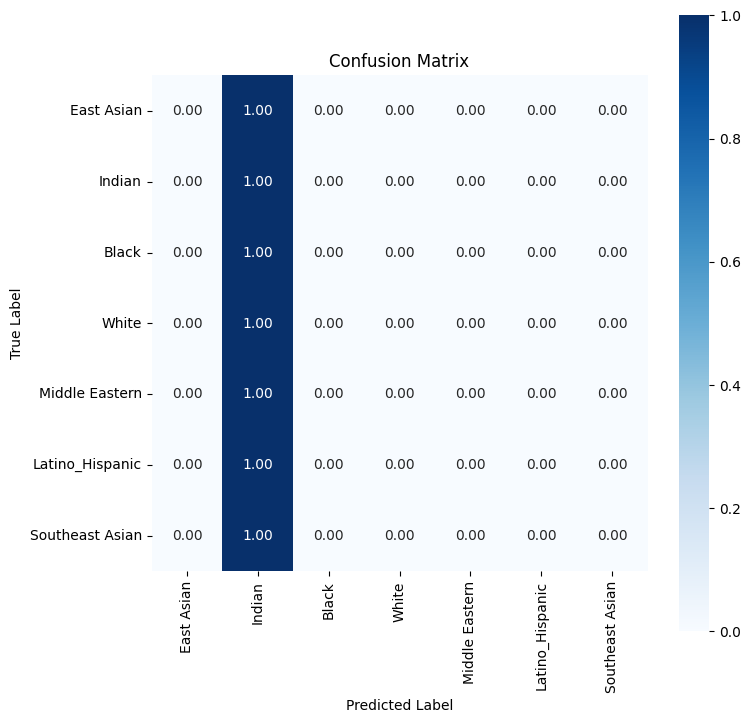

In [ ]:
plot_confusion_matrix(cm, classes.keys())

## Epoch Loss

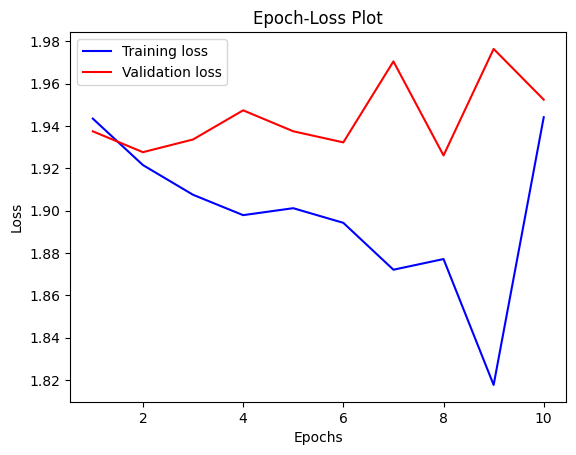

In [ ]:
plot_epcoh_loss(history)

## Accuracy Loss

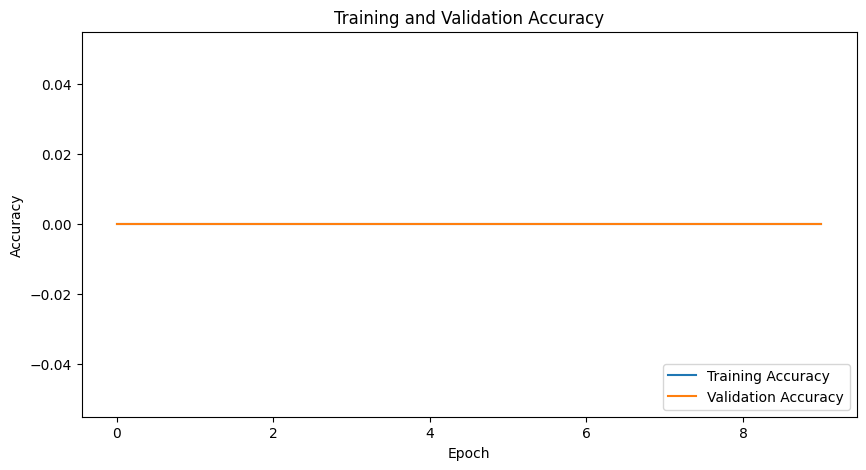

In [ ]:
plot_accuracy_loss(history)

# Task 4: Your own Convolutional Neural Network on both Tasks Simultaneously

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

## Dual Tasks Model

In [ ]:
def dual_tasks_model(n_classes:dict):
    global X_test

    # create input layer
    input_layer = Input(shape=X_test[-1].shape)

    # create convolutional layers for image classification task
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_layer)
    pool1 = MaxPooling2D((2, 2), name='pool1')(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(pool1)
    pool2 = MaxPooling2D((2, 2), name='pool2')(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(pool2)
    pool3 = MaxPooling2D((2, 2), name='pool3')(conv3)
    flatten1 = Flatten(name='flatten1')(pool3)
    dense1_0 = Dense(128, activation='relu', name='dense1_0')(flatten1)
    dense1_1 = Dense(64, activation='relu', name='dense1_1')(dense1_0)
    dense1_2 = Dense(len(n_classes['gender']), activation='softmax', name='dense1_2')(dense1_1)

    # create convolutional layers for object detection task
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv4')(input_layer)
    pool4 = MaxPooling2D((2, 2), name='pool4')(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5')(pool4)
    pool5 = MaxPooling2D((2, 2), name='pool5')(conv5)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6')(pool5)
    pool6 = MaxPooling2D((2, 2), name='pool6')(conv6)
    flatten2 = Flatten(name='flatten2')(pool6)
    dense2_0 = Dense(1024, activation='relu', name='dense2_0')(flatten2)
    dense2_1 = Dense(512, activation='relu', name='dense2_1')(dense2_0)
    dense2_2 = Dense(len(n_classes['race']), activation='sigmoid', name='dense2_2')(dense2_1)

    # create the model with two output branches
    model = tf.keras.models.Model(inputs=input_layer, outputs=[dense1_2, dense2_2])

    # compile the model with Mini-batch gradient descent optimizer
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], 
                # loss_weights=[1.0, 1.0],
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
                metrics=['accuracy']) #tf.keras.metrics.Accuracy(name='gender_accuracy'), tf.keras.metrics.Accuracy(name='race_accuracy')])

    return model

## Perform Learning 

### Scaling Images

In [ ]:
# Scale the data using Min-Max scaling
X_train = (train_images - train_images.min()) / (train_images.max() - train_images.min())
X_test = (valid_images - train_images.min()) / (train_images.max() - train_images.min())

### Format Classes and Labels

In [ ]:
classes, labels = classes_and_encoded_labels(['gender', 'race'])
classes

{'gender': {'Male': 0, 'Female': 1},
 'race': {'East Asian': 0,
  'Indian': 1,
  'Black': 2,
  'White': 3,
  'Middle Eastern': 4,
  'Latino_Hispanic': 5,
  'Southeast Asian': 6}}

### Create Model

In [ ]:
multitask_cnn = dual_tasks_model(classes)
multitask_cnn.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 32, 32, 32)   896         ['input_16[0][0]']               
                                                                                                  
 conv4 (Conv2D)                 (None, 32, 32, 64)   1792        ['input_16[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)           (None, 16, 16, 32)   0           ['conv1[0][0]']                  
                                                                                            

### Train Model

In [ ]:
history = multitask_cnn.fit(X_train, [labels['gender']['train'], labels['race']['train']], batch_size=32, epochs=10, validation_split=0.2)
history.history

Epoch 1/10
5/5 [==============================] - 5s 572ms/step - loss: 2.6406 - dense1_2_loss: 0.7042 - dense2_2_loss: 1.9364 - dense1_2_accuracy: 0.4313 - dense2_2_accuracy: 0.1750 - val_loss: 2.6226 - val_dense1_2_loss: 0.6924 - val_dense2_2_loss: 1.9303 - val_dense1_2_accuracy: 0.5250 - val_dense2_2_accuracy: 0.2250
Epoch 2/10
5/5 [==============================] - 2s 418ms/step - loss: 2.6106 - dense1_2_loss: 0.6911 - dense2_2_loss: 1.9195 - dense1_2_accuracy: 0.5437 - dense2_2_accuracy: 0.2125 - val_loss: 2.6369 - val_dense1_2_loss: 0.7025 - val_dense2_2_loss: 1.9344 - val_dense1_2_accuracy: 0.3750 - val_dense2_2_accuracy: 0.2000
Epoch 3/10
5/5 [==============================] - 2s 404ms/step - loss: 2.6050 - dense1_2_loss: 0.6893 - dense2_2_loss: 1.9157 - dense1_2_accuracy: 0.5500 - dense2_2_accuracy: 0.2375 - val_loss: 2.6288 - val_dense1_2_loss: 0.6953 - val_dense2_2_loss: 1.9335 - val_dense1_2_accuracy: 0.5000 - val_dense2_2_accuracy: 0.2250
Epoch 4/10
5/5 [==================

{'loss': [2.640584945678711,
  2.6106173992156982,
  2.6049704551696777,
  2.5873067378997803,
  2.6015982627868652,
  2.5787529945373535,
  2.5630366802215576,
  2.517587423324585,
  2.506155490875244,
  2.496410608291626],
 'dense1_2_loss': [0.7041603326797485,
  0.691120982170105,
  0.6892772912979126,
  0.6855961084365845,
  0.708106517791748,
  0.6988821029663086,
  0.691307008266449,
  0.6929545998573303,
  0.6951325535774231,
  0.6901654005050659],
 'dense2_2_loss': [1.9364246129989624,
  1.9194965362548828,
  1.9156932830810547,
  1.9017107486724854,
  1.893491506576538,
  1.8798706531524658,
  1.871729850769043,
  1.8246328830718994,
  1.8110229969024658,
  1.8062450885772705],
 'dense1_2_accuracy': [0.4312500059604645,
  0.543749988079071,
  0.550000011920929,
  0.512499988079071,
  0.4749999940395355,
  0.5249999761581421,
  0.5249999761581421,
  0.512499988079071,
  0.512499988079071,
  0.5249999761581421],
 'dense2_2_accuracy': [0.17499999701976776,
  0.21250000596046448,


In [ ]:
eval_results = multitask_cnn.evaluate(X_test, [labels['gender']['test'], labels['race']['test']])
eval_results

2/2 [==============================] - 0s 41ms/step - loss: 2.7203 - dense1_2_loss: 0.6895 - dense2_2_loss: 2.0308 - dense1_2_accuracy: 0.5000 - dense2_2_accuracy: 0.2000


[2.720263719558716,
 0.6895083785057068,
 2.0307552814483643,
 0.5,
 0.20000000298023224]

In [ ]:
print("Final Validation Loss:", eval_results[0])
print("Final Validation Loss (Gender):", eval_results[1])
print("Final Validation Loss (Race):", eval_results[2])
print("Final Validation Accuracy (Gender):", eval_results[3])
print("Final Validation Accuracy (Race):", eval_results[4])

Final Validation Loss: 2.720263719558716
Final Validation Loss (Gender): 0.6895083785057068
Final Validation Loss (Race): 2.0307552814483643
Final Validation Accuracy (Gender): 0.5
Final Validation Accuracy (Race): 0.20000000298023224


### Predict

In [ ]:
y_pred_gender, y_pred_race = multitask_cnn.predict(X_test)

y_pred_gender = np.argmax(y_pred_gender, axis=1)
cm_gender = tf.math.confusion_matrix(np.argmax(labels['gender']['test'], axis=1), y_pred_gender)
print('Confusion Matrix Gender Detection:\n', cm_gender)

y_pred_race = np.argmax(y_pred_race, axis=1)
cm_race = tf.math.confusion_matrix(np.argmax(labels['race']['test'], axis=1), y_pred_race)
print('Confusion Matrix Race Detection:\n', cm_race)

2/2 [==============================] - 1s 31ms/step
Confusion Matrix Gender Detection:
 tf.Tensor(
[[20  0]
 [20  0]], shape=(2, 2), dtype=int32)
Confusion Matrix Race Detection:
 tf.Tensor(
[[1 7 0 0 0 2 0]
 [1 3 0 1 0 0 0]
 [0 3 0 1 0 0 0]
 [0 2 0 1 0 1 1]
 [1 2 0 0 0 1 0]
 [0 3 0 2 0 2 0]
 [0 1 1 1 0 1 1]], shape=(7, 7), dtype=int32)


### Confusion Matrix

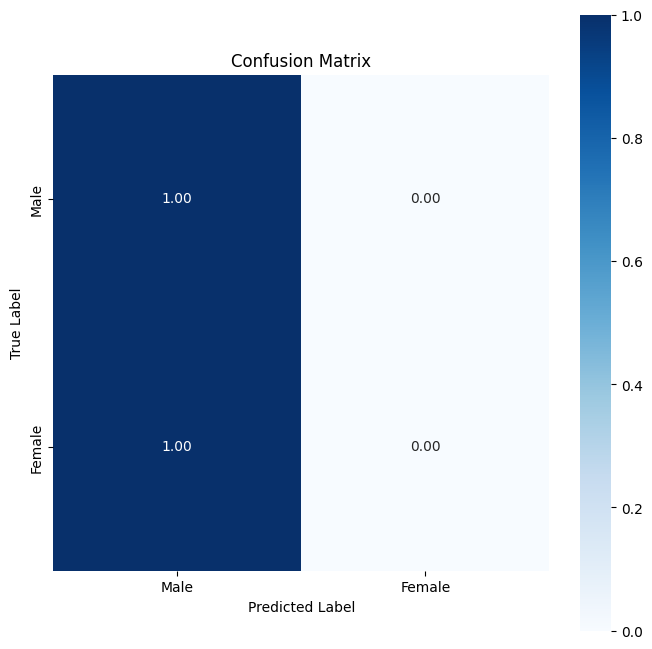

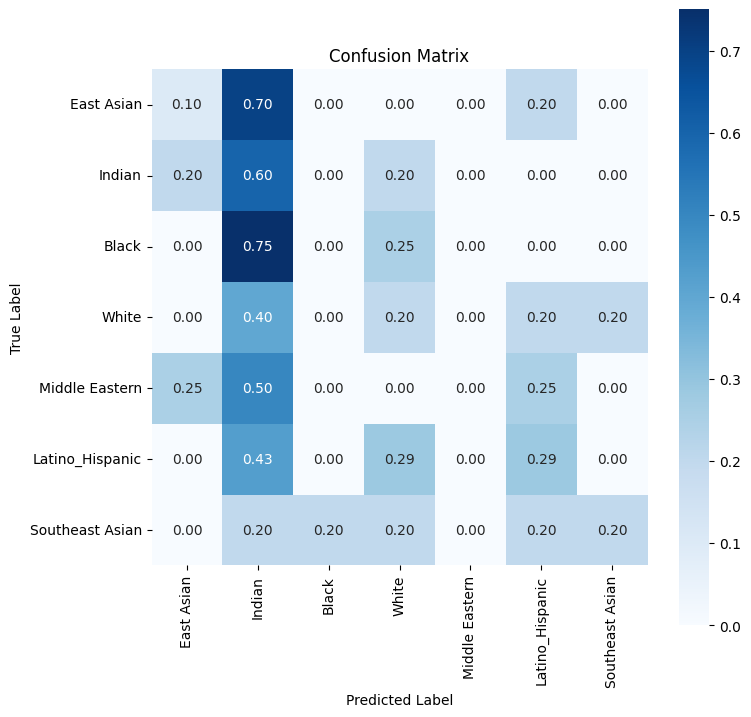

In [ ]:
plot_confusion_matrix(cm_gender, classes['gender'].keys())
plot_confusion_matrix(cm_race, classes['race'].keys())

### Epoch Loss

In [ ]:
history.history.keys()

dict_keys(['loss', 'dense1_2_loss', 'dense2_2_loss', 'dense1_2_accuracy', 'dense2_2_accuracy', 'val_loss', 'val_dense1_2_loss', 'val_dense2_2_loss', 'val_dense1_2_accuracy', 'val_dense2_2_accuracy'])

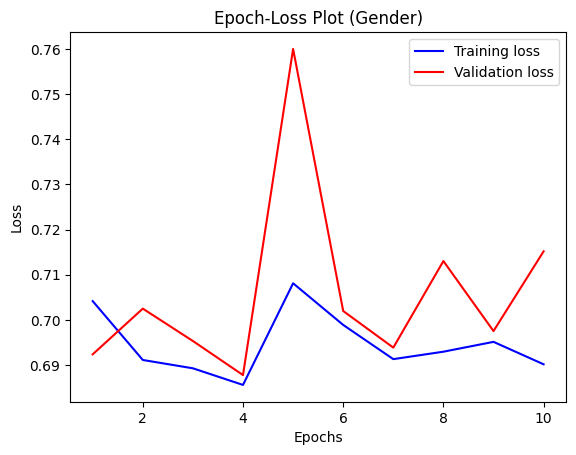

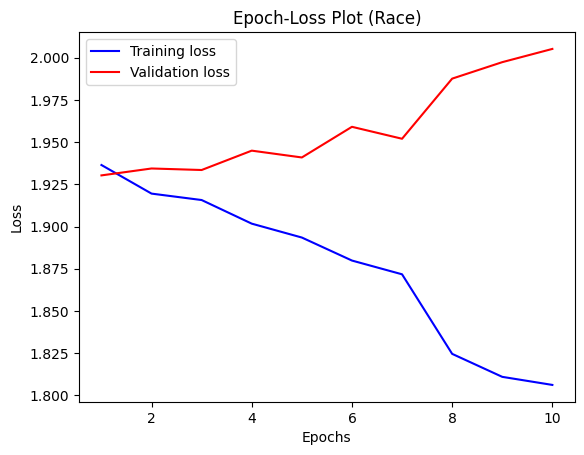

In [ ]:
# Extract the loss values for the training and validation sets from the history object
train_loss = history.history['dense1_2_loss']
val_loss = history.history['val_dense1_2_loss']

# Plot the epoch-loss curve
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Epoch-Loss Plot (Gender)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract the loss values for the training and validation sets from the history object
train_loss = history.history['dense2_2_loss']
val_loss = history.history['val_dense2_2_loss']

# Plot the epoch-loss curve
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Epoch-Loss Plot (Race)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy Loss

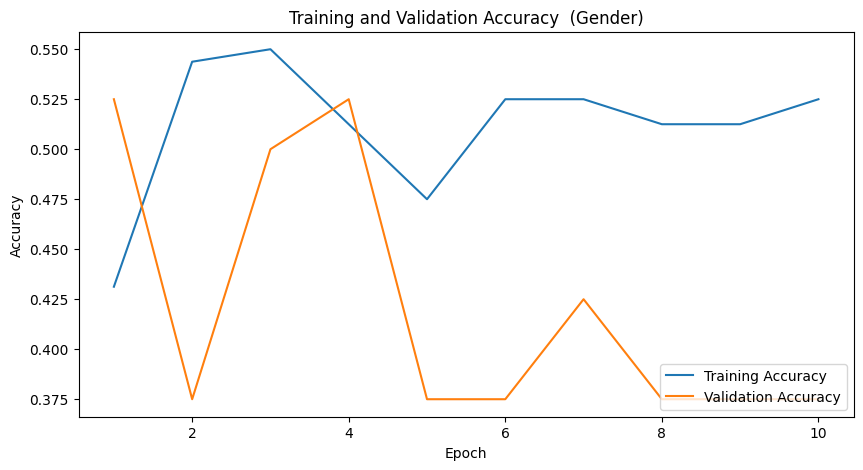

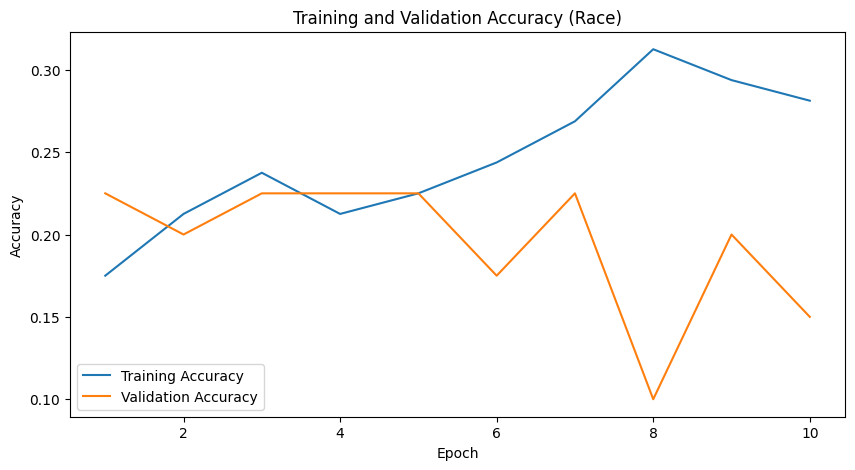

In [ ]:
# Get training and validation accuracy values
acc = history.history['dense1_2_accuracy']
val_acc = history.history['val_dense1_2_accuracy']

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy  (Gender)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Get training and validation accuracy values
acc = history.history['dense2_2_accuracy']
val_acc = history.history['val_dense2_2_accuracy']

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy (Race)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Task 5: Variational Auto Encoder
 (Inspired from Keras Example @ https://keras.io/examples/generative/vae/)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

## Classes & Labels

In [ ]:
classes, labels = classes_and_encoded_labels(['gender', 'race'])

In [ ]:
y_test = labels['gender']['test']
y_train = labels['gender']['train']

## Scaling Images

In [ ]:
# Scale the data using Min-Max scaling
X_train = (train_images - train_images.min()) / (train_images.max() - train_images.min())
X_test = (valid_images - train_images.min()) / (train_images.max() - train_images.min())

## Sampling Layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [ ]:
latent_dim = 5
encoder_inputs = keras.Input(shape=X_train[-1].shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_29 (Conv2D)             (None, 16, 16, 32)   896         ['input_17[0][0]']               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 8, 8, 64)     18496       ['conv2d_29[0][0]']              
                                                                                                  
 flatten_23 (Flatten)           (None, 4096)         0           ['conv2d_30[0][0]']              
                                                                                            

## Decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_63 (Dense)            (None, 3136)              18816     
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 28, 28, 3)        867 

## VAE Model

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            data_resized = tf.image.resize(
                data, size=reconstruction.shape[1:3], method=tf.image.ResizeMethod.BILINEAR
            )
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data_resized, reconstruction[..., 0:1]), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.mse_metric = keras.metrics.MeanSquaredError(name='mse')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.mse_metric,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            data_resized = tf.image.resize(
                data, size=reconstruction.shape[1:3], method=tf.image.ResizeMethod.BILINEAR
            )
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data_resized, reconstruction[..., 0:1]), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_metric.update_state(data_resized, reconstruction[..., 0:1])
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mse": self.mse_metric.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

## Train VAE

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9))

In [ ]:
history = vae.fit(X_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
5/5 [==============================] - 6s 598ms/step - loss: 533.8343 - reconstruction_loss: 532.3539 - kl_loss: 0.0320 - mse: 0.0554 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 1s 169ms/step - loss: 516.0046 - reconstruction_loss: 520.2682 - kl_loss: 0.0154 - mse: 0.0481 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 1s 145ms/step - loss: 518.4582 - reconstruction_loss: 520.1842 - kl_loss: 0.0069 - mse: 0.0481 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 1s 174ms/step - loss: 517.6713 - reconstruction_loss: 519.3795 - kl_loss: 0.0059 - mse: 0.0476 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl

## Predict

In [ ]:
X_pred = vae.predict(X_test)

2/2 [==============================] - 1s 16ms/step


## Accuracy

In [ ]:
# Calculate the accuracy
X_test_resized = tf.image.resize(X_test, size=(28, 28), method=tf.image.ResizeMethod.BILINEAR)
accuracy = tf.reduce_mean(tf.cast(tf.equal(X_test_resized, X_pred), tf.float32))
accuracy.numpy()

0.0

## Epoch Loss & Accuracy Loss

In [ ]:
history.history

{'loss': [532.3858642578125,
  520.2836303710938,
  520.191162109375,
  519.3853759765625,
  519.4346923828125,
  519.3712158203125,
  518.697998046875,
  519.3999633789062,
  519.7200927734375,
  519.39794921875],
 'reconstruction_loss': [532.3538818359375,
  520.2681884765625,
  520.1842041015625,
  519.3795166015625,
  519.4295654296875,
  519.3675537109375,
  518.6953125,
  519.3978271484375,
  519.7183837890625,
  519.3963623046875],
 'kl_loss': [0.031974244862794876,
  0.015446046367287636,
  0.006940062157809734,
  0.005870199296623468,
  0.005029225256294012,
  0.0036120854783803225,
  0.0026734271086752415,
  0.0021273966412991285,
  0.001813808223232627,
  0.0016058215405791998],
 'mse': [0.055385492742061615,
  0.04808448627591133,
  0.04805607721209526,
  0.04756416752934456,
  0.04760803282260895,
  0.04755377024412155,
  0.04716141149401665,
  0.04758947715163231,
  0.04775732383131981,
  0.04758350923657417],
 'val_total_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

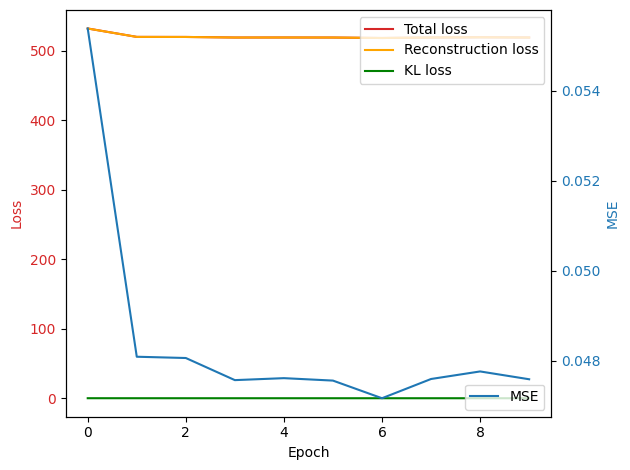

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.history['loss'], color=color)
ax1.plot(history.history['reconstruction_loss'], color='orange')
ax1.plot(history.history['kl_loss'], color='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['Total loss', 'Reconstruction loss', 'KL loss'], loc='upper right')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('MSE', color=color)
ax2.plot(history.history['mse'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['MSE'], loc='lower right')

fig.tight_layout()
plt.show()

## Qualitative Evaluation

1/1 [==============================] - 1s 550ms/step


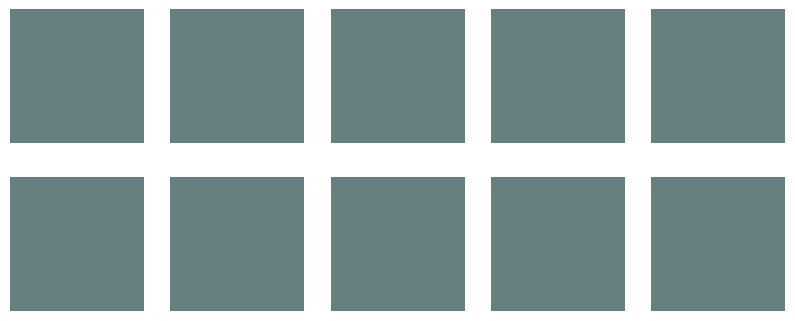

In [ ]:
# Generate 10 random latent vectors
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Use the decoder to generate images from the random latent vectors
generated_images = decoder.predict(random_latent_vectors)

# Plot the generated images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
axs = axs.ravel()

for i in range(len(generated_images)):
    axs[i].imshow(generated_images[i], cmap='gray')
    axs[i].axis('off')
plt.show()

# Conclusion

Our group was able to demonstrate how we were able to build a model to classify images based on facial attributes. We ran in to issues initially due to the size of the dataset. To alieviate the issues we opted to train our model based on a subset of the training and validation data. This allowed our program to excute the code, which also allowed us to show the necessary graphs and accuracies. 
